In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [95]:
sinfo=pd.read_csv("subject_info.csv")
ecg_data=pd.read_csv("test_measure.csv")

<Axes: >

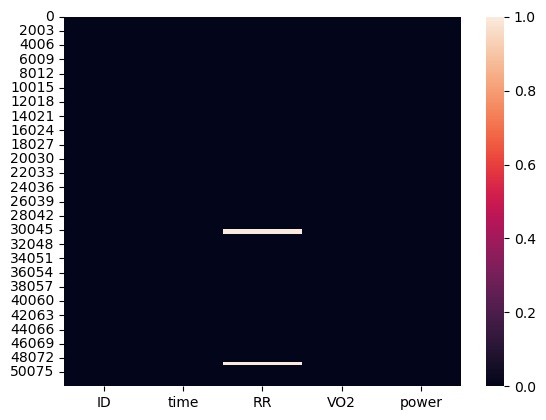

In [96]:
sns.heatmap(ecg_data.isnull())

# 1. Data Cleaning - Removing the rows

In [97]:
# Remove values of RR too big
ecg_data = ecg_data[~((ecg_data['RR'] > 1000) & (ecg_data['power'] > 0))]
#df.drop(df['RR']>1000)

ecg_data

,ID,time,RR,VO2,power
0,1,-130.840,672.0,0.302008,0
1,1,-130.168,672.0,0.302008,0
2,1,-129.536,632.0,0.301336,0
3,1,-128.824,712.0,0.301336,0
4,1,-127.948,876.0,0.301336,0
...,...,...,...,...,...
52057,18,947.288,536.0,0.507071,0
52058,18,947.816,528.0,0.507071,0
52059,18,948.344,528.0,0.507071,0
52060,18,948.884,540.0,0.507071,0


In [98]:
ecg_data_c = ecg_data.copy()

In [99]:
# remove RR values way above their surrounding value
ecg_data_c['RR_av'] = ecg_data_c.groupby('ID')['RR'].rolling(201).median().values
ecg_data_c = ecg_data_c[~((ecg_data_c['RR'] > ecg_data_c['RR_av']*2) | (ecg_data_c['RR'] < 0.5*ecg_data_c['RR_av']))]
ecg_data_c.drop(columns=['RR_av'], inplace=True)

ecg_data_c


,ID,time,RR,VO2,power
0,1,-130.840,672.0,0.302008,0
1,1,-130.168,672.0,0.302008,0
2,1,-129.536,632.0,0.301336,0
3,1,-128.824,712.0,0.301336,0
4,1,-127.948,876.0,0.301336,0
...,...,...,...,...,...
52057,18,947.288,536.0,0.507071,0
52058,18,947.816,528.0,0.507071,0
52059,18,948.344,528.0,0.507071,0
52060,18,948.884,540.0,0.507071,0


In [100]:
# remove points increasing more than 10 time the normal surrounding increase
for i in range(15):
    print(i+1)
    ecg_data_c['diffRR'] = np.abs(ecg_data_c['RR'].diff())
    ecg_data_c['diffRR_av'] = ecg_data_c.groupby('ID')['diffRR'].rolling(201).median().values
    ecg_data_c['pb'] = (ecg_data_c['diffRR'] > 10*ecg_data_c['diffRR_av']) & (ecg_data_c['diffRR_av'] != 0)
    ecg_data_c['pb_before'] = ecg_data_c.groupby('ID')['pb'].shift(1)
    ecg_data_c.loc[(ecg_data_c['pb'] == 1) & (ecg_data_c['pb_before'] == 1), 'pb'] = 0
    print(ecg_data_c[ecg_data_c['pb'] == 1]['pb'].sum()/ecg_data_c.shape[0])
    ecg_data_c = ecg_data_c[ecg_data_c['pb'] == 0]
ecg_data_c

1
0.0026127718435410745
2
0.0004237614608213268
3
5.781015146259683e-05
4
3.85423291129483e-05
5
3.854381468133901e-05
6


C:\Users\garin\AppData\Local\Temp\ipykernel_36220\3089378592.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecg_data_c['diffRR'] = np.abs(ecg_data_c['RR'].diff())
C:\Users\garin\AppData\Local\Temp\ipykernel_36220\3089378592.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecg_data_c['diffRR_av'] = ecg_data_c.groupby('ID')['diffRR'].rolling(201).median().values
C:\Users\garin\AppData\Local\Temp\ipykernel_36220\3089378592.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

1.9272650182126543e-05
7
1.9273021624330263e-05
8
1.9273393080851885e-05
9
1.9273764551692237e-05
10
1.9274136036852148e-05
11
1.9274507536332445e-05
12
1.927487905013396e-05
13
1.9275250578257516e-05
14
1.9275622120703946e-05
15
1.9275993677474075e-05


,ID,time,RR,VO2,power,diffRR,diffRR_av,pb,pb_before
0,1,-130.840,672.0,0.302008,0,NaN,NaN,False,NaN
1,1,-130.168,672.0,0.302008,0,0.0,NaN,False,False
2,1,-129.536,632.0,0.301336,0,40.0,NaN,False,False
3,1,-128.824,712.0,0.301336,0,80.0,NaN,False,False
4,1,-127.948,876.0,0.301336,0,164.0,NaN,False,False
...,...,...,...,...,...,...,...,...,...
52057,18,947.288,536.0,0.507071,0,8.0,8.0,False,False
52058,18,947.816,528.0,0.507071,0,8.0,8.0,False,False
52059,18,948.344,528.0,0.507071,0,0.0,8.0,False,False
52060,18,948.884,540.0,0.507071,0,12.0,8.0,False,False


In [101]:
ecg_data_c.shape

(51877, 9)

In [102]:
ecg_data

,ID,time,RR,VO2,power
0,1,-130.840,672.0,0.302008,0
1,1,-130.168,672.0,0.302008,0
2,1,-129.536,632.0,0.301336,0
3,1,-128.824,712.0,0.301336,0
4,1,-127.948,876.0,0.301336,0
...,...,...,...,...,...
52057,18,947.288,536.0,0.507071,0
52058,18,947.816,528.0,0.507071,0
52059,18,948.344,528.0,0.507071,0
52060,18,948.884,540.0,0.507071,0


In [103]:
ecg_data['remain'] = 1
ecg_data['remain'] = ecg_data['remain'].astype(float)

ecg_data['remain'] = ecg_data.groupby(['ID', 'time'])['remain'] \
              .transform(lambda x: 1 if len(x.notna()) > 0 else 0)

# Test Column

In [107]:
ecg_data = ecg_data[ecg_data['remain'] == 1]

# define test sequence
ecg_data['power_idx'] = ecg_data.groupby('ID')['power'].apply(lambda x: (x != x.shift(1)).cumsum())
last_power_idx = ecg_data.groupby('ID')['power_idx'].max().reset_index().rename(columns={'power_idx': 'last_power_idx'})
ecg_data = ecg_data.merge(last_power_idx, on='ID')
ecg_data['test'] = np.select([(ecg_data['power_idx'] == 1), (ecg_data['power_idx'] == ecg_data['last_power_idx']), (True)], ['rest', 'recovery', 'test'])

C:\Users\garin\AppData\Local\Temp\ipykernel_36220\3064027624.py:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ecg_data['power_idx'] = ecg_data.groupby('ID')['power'].apply(lambda x: (x != x.shift(1)).cumsum())


KeyError: 'last_power_idx'

In [108]:
ecg_data['test'].unique()

array(['rest', 'test', 'recovery'], dtype=object)

In [109]:
ecg_data

,ID,time,RR,VO2,power,remain,power_idx,last_power_idx_x,test,last_power_idx_y
0,1,-130.840,672.0,0.302008,0,1,1,11,rest,11
1,1,-130.168,672.0,0.302008,0,1,1,11,rest,11
2,1,-129.536,632.0,0.301336,0,1,1,11,rest,11
3,1,-128.824,712.0,0.301336,0,1,1,11,rest,11
4,1,-127.948,876.0,0.301336,0,1,1,11,rest,11
...,...,...,...,...,...,...,...,...,...,...
52050,18,947.288,536.0,0.507071,0,1,13,13,recovery,13
52051,18,947.816,528.0,0.507071,0,1,13,13,recovery,13
52052,18,948.344,528.0,0.507071,0,1,13,13,recovery,13
52053,18,948.884,540.0,0.507071,0,1,13,13,recovery,13


# 2.  Data Cleaning - Adding Columns (HR)

In [110]:
ecg_data['HR'] = 60000/ecg_data['RR']
ecg_data

,ID,time,RR,VO2,power,remain,power_idx,last_power_idx_x,test,last_power_idx_y,HR
0,1,-130.840,672.0,0.302008,0,1,1,11,rest,11,89.285714
1,1,-130.168,672.0,0.302008,0,1,1,11,rest,11,89.285714
2,1,-129.536,632.0,0.301336,0,1,1,11,rest,11,94.936709
3,1,-128.824,712.0,0.301336,0,1,1,11,rest,11,84.269663
4,1,-127.948,876.0,0.301336,0,1,1,11,rest,11,68.493151
...,...,...,...,...,...,...,...,...,...,...,...
52050,18,947.288,536.0,0.507071,0,1,13,13,recovery,13,111.940299
52051,18,947.816,528.0,0.507071,0,1,13,13,recovery,13,113.636364
52052,18,948.344,528.0,0.507071,0,1,13,13,recovery,13,113.636364
52053,18,948.884,540.0,0.507071,0,1,13,13,recovery,13,111.111111


# Time_Rest column

In [111]:
def calculate_time_rest(group):
    recovery_times = ecg_data[ecg_data['test'] == 'recovery'].groupby('ID')['time'].first()
    id = group['ID'].iloc[0]
    first_recovery_time = recovery_times.loc[id]
    time_rest = group['time'] - first_recovery_time
    return time_rest

ecg_data['time_rest'] = ecg_data.groupby('ID').apply(calculate_time_rest).reset_index(drop=True)


In [112]:
ecg_data

,ID,time,RR,VO2,power,remain,power_idx,last_power_idx_x,test,last_power_idx_y,HR,time_rest
0,1,-130.840,672.0,0.302008,0,1,1,11,rest,11,89.285714,-785.020
1,1,-130.168,672.0,0.302008,0,1,1,11,rest,11,89.285714,-784.348
2,1,-129.536,632.0,0.301336,0,1,1,11,rest,11,94.936709,-783.716
3,1,-128.824,712.0,0.301336,0,1,1,11,rest,11,84.269663,-783.004
4,1,-127.948,876.0,0.301336,0,1,1,11,rest,11,68.493151,-782.128
...,...,...,...,...,...,...,...,...,...,...,...,...
52050,18,947.288,536.0,0.507071,0,1,13,13,recovery,13,111.940299,199.284
52051,18,947.816,528.0,0.507071,0,1,13,13,recovery,13,113.636364,199.812
52052,18,948.344,528.0,0.507071,0,1,13,13,recovery,13,113.636364,200.340
52053,18,948.884,540.0,0.507071,0,1,13,13,recovery,13,111.111111,200.880


# HR_Mean and Vo2 Mean

In [136]:
ecg_data['HR_mean'] = ecg_data.groupby('ID')['HR'].rolling(window=100, min_periods=1).mean().reset_index(drop=True)
ecg_data['VO2_mean'] = ecg_data.groupby('ID')['VO2'].rolling(window=100, min_periods=1).mean().reset_index(drop=True)

In [137]:
ecg_data

,ID,time,RR,VO2,power,remain,power_idx,last_power_idx_x,test,last_power_idx_y,HR,time_rest,HR_mean,VO2_mean
0,1,-130.840,672.0,0.302008,0,1,1,11,rest,11,89.29,-785.020,89.290000,0.302008
1,1,-130.168,672.0,0.302008,0,1,1,11,rest,11,89.29,-784.348,89.290000,0.302008
2,1,-129.536,632.0,0.301336,0,1,1,11,rest,11,94.94,-783.716,91.173333,0.301784
3,1,-128.824,712.0,0.301336,0,1,1,11,rest,11,84.27,-783.004,89.447500,0.301672
4,1,-127.948,876.0,0.301336,0,1,1,11,rest,11,68.49,-782.128,85.256000,0.301604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52050,18,947.288,536.0,0.507071,0,1,13,13,recovery,13,111.94,199.284,115.033200,0.461490
52051,18,947.816,528.0,0.507071,0,1,13,13,recovery,13,113.64,199.812,114.979100,0.460423
52052,18,948.344,528.0,0.507071,0,1,13,13,recovery,13,113.64,200.340,114.934400,0.459355
52053,18,948.884,540.0,0.507071,0,1,13,13,recovery,13,111.11,200.880,114.855000,0.458288


In [138]:
test_max = ecg_data.groupby('ID').agg(
    HRmax=('HR_mean', 'max'),
    VO2max_abs=('VO2_mean', 'max'),
    powermax=('power', 'max')
)
test_max.reset_index(inplace=True)

In [139]:
test_max

,ID,HRmax,VO2max_abs,powermax
0,1,193.3654,1.556423,170
1,2,182.6176,1.795964,140
2,3,177.2230,3.240769,305
3,4,194.8609,2.797500,305
4,5,186.7684,3.131456,275
5,6,182.1509,2.892842,245
6,7,186.0443,1.322388,170
7,8,182.7956,1.839425,170
8,9,188.4966,1.552537,200
9,10,190.0952,2.032672,200


# HRR120 and HRR60

In [117]:
recovery_data = ecg_data[ecg_data['test'] == "recovery"]
HRR = recovery_data.groupby('ID').apply(lambda group: pd.Series({
    'HRR120': group['HR_mean'].iloc[0] - group[group['time_rest'] > 120]['HR_mean'].iloc[0],
    'HRR60': group['HR_mean'].iloc[0] - group[group['time_rest'] > 60]['HR_mean'].iloc[0]
})).reset_index()

In [118]:
HRR

,ID,HRR120,HRR60
0,1,43.523723,15.369819
1,2,56.615911,29.817986
2,3,44.779881,17.189525
3,4,40.056916,16.113339
4,5,44.284435,23.198961
5,6,52.410268,26.028475
6,7,60.814530,31.121756
7,8,54.002904,24.672129
8,9,40.372876,19.721101
9,10,30.664786,16.246111


In [119]:
Cleaned_sinfo = pd.merge(pd.merge(sinfo, test_max, on='ID'), HRR, on='ID')

In [120]:
Cleaned_sinfo['VO2max']=Cleaned_sinfo['VO2max_abs']/Cleaned_sinfo['Weight']
Cleaned_sinfo

,ID,age,Weight,Height,P_vt1,P_vt2,sport,HRmax,VO2max_abs,powermax,HRR120,HRR60,VO2max
0,1,15,53.7,161,50,140,fencing,193.362384,1.556423,170,43.523723,15.369819,0.028984
1,2,15,56.2,162,80,127,fencing,182.615885,1.795964,140,56.615911,29.817986,0.031957
2,3,16,89.9,191,155,300,fencing,177.223686,3.240769,305,44.779881,17.189525,0.036049
3,4,16,76.5,180,215,275,fencing,194.857957,2.797500,305,40.056916,16.113339,0.036569
4,5,17,76.4,186,110,172,fencing,186.766835,3.131456,275,44.284435,23.198961,0.040988
5,6,17,65.6,169,131,186,fencing,182.150183,2.892842,245,52.410268,26.028475,0.044098
6,7,15,49.8,165,65,108,fencing,186.042266,1.322388,170,60.814530,31.121756,0.026554
7,8,15,51.2,165,80,133,fencing,182.794291,1.839425,170,54.002904,24.672129,0.035926
8,9,14,57.1,176,50,125,fencing,188.498008,1.552537,200,40.372876,19.721101,0.027190
9,10,14,58.8,177,101,162,fencing,190.097371,2.032672,200,30.664786,16.246111,0.034569


# HR Rest

In [121]:
rest_data = ecg_data[ecg_data['test'] == "rest"]
HR_rest['HRrest'] = rest_data.groupby(['ID'])['HR'].mean()
HR_rest['HRrest']

ID
1     79.985934
2     66.852916
3     79.782809
4     91.996077
5     80.976800
6     69.492282
7     83.641122
8     67.542460
9     89.687842
10    78.849387
11    87.210828
12    83.592148
13    90.186877
14    78.368361
15    75.705102
16    81.778446
17    79.896108
18    71.021997
Name: HR, dtype: float64

In [122]:

insightcrew_cleaneddata = pd.merge(Cleaned_sinfo,HR_rest, on='ID')

In [123]:
insightcrew_cleaneddata=insightcrew_cleaneddata.rename(columns={'HR': 'HRrest'})


In [124]:
print(insightcrew_cleaneddata)

    ID  age  Weight  Height  P_vt1  P_vt2      sport       HRmax  VO2max_abs  \
0    1   15    53.7     161     50    140    fencing  193.362384    1.556423   
1    2   15    56.2     162     80    127    fencing  182.615885    1.795964   
2    3   16    89.9     191    155    300    fencing  177.223686    3.240769   
3    4   16    76.5     180    215    275    fencing  194.857957    2.797500   
4    5   17    76.4     186    110    172    fencing  186.766835    3.131456   
5    6   17    65.6     169    131    186    fencing  182.150183    2.892842   
6    7   15    49.8     165     65    108    fencing  186.042266    1.322388   
7    8   15    51.2     165     80    133    fencing  182.794291    1.839425   
8    9   14    57.1     176     50    125    fencing  188.498008    1.552537   
9   10   14    58.8     177    101    162    fencing  190.097371    2.032672   
10  11   18    84.8     182    174    268      kayak  183.953028    3.088813   
11  12   18    86.0     183    170    29

# Prediction of HR max based on age

In [125]:
insightcrew_cleaneddata['MaxHR_Pred']=220-insightcrew_cleaneddata['age']
insightcrew_cleaneddata

,ID,age,Weight,Height,P_vt1,P_vt2,sport,HRmax,VO2max_abs,powermax,HRR120,HRR60,VO2max,HRrest,MaxHR_Pred
0,1,15,53.7,161,50,140,fencing,193.362384,1.556423,170,43.523723,15.369819,0.028984,79.985934,205
1,2,15,56.2,162,80,127,fencing,182.615885,1.795964,140,56.615911,29.817986,0.031957,66.852916,205
2,3,16,89.9,191,155,300,fencing,177.223686,3.240769,305,44.779881,17.189525,0.036049,79.782809,204
3,4,16,76.5,180,215,275,fencing,194.857957,2.797500,305,40.056916,16.113339,0.036569,91.996077,204
4,5,17,76.4,186,110,172,fencing,186.766835,3.131456,275,44.284435,23.198961,0.040988,80.9768,203
5,6,17,65.6,169,131,186,fencing,182.150183,2.892842,245,52.410268,26.028475,0.044098,69.492282,203
6,7,15,49.8,165,65,108,fencing,186.042266,1.322388,170,60.814530,31.121756,0.026554,83.641122,205
7,8,15,51.2,165,80,133,fencing,182.794291,1.839425,170,54.002904,24.672129,0.035926,67.54246,205
8,9,14,57.1,176,50,125,fencing,188.498008,1.552537,200,40.372876,19.721101,0.027190,89.687842,206
9,10,14,58.8,177,101,162,fencing,190.097371,2.032672,200,30.664786,16.246111,0.034569,78.849387,206


#  ATHR 

In [126]:
insightcrew_cleaneddata['ATHR']=insightcrew_cleaneddata['HRmax']*0.85
insightcrew_cleaneddata

,ID,age,Weight,Height,P_vt1,P_vt2,sport,HRmax,VO2max_abs,powermax,HRR120,HRR60,VO2max,HRrest,MaxHR_Pred,ATHR
0,1,15,53.7,161,50,140,fencing,193.362384,1.556423,170,43.523723,15.369819,0.028984,79.985934,205,164.358026
1,2,15,56.2,162,80,127,fencing,182.615885,1.795964,140,56.615911,29.817986,0.031957,66.852916,205,155.223502
2,3,16,89.9,191,155,300,fencing,177.223686,3.240769,305,44.779881,17.189525,0.036049,79.782809,204,150.640133
3,4,16,76.5,180,215,275,fencing,194.857957,2.797500,305,40.056916,16.113339,0.036569,91.996077,204,165.629263
4,5,17,76.4,186,110,172,fencing,186.766835,3.131456,275,44.284435,23.198961,0.040988,80.9768,203,158.751810
5,6,17,65.6,169,131,186,fencing,182.150183,2.892842,245,52.410268,26.028475,0.044098,69.492282,203,154.827656
6,7,15,49.8,165,65,108,fencing,186.042266,1.322388,170,60.814530,31.121756,0.026554,83.641122,205,158.135926
7,8,15,51.2,165,80,133,fencing,182.794291,1.839425,170,54.002904,24.672129,0.035926,67.54246,205,155.375147
8,9,14,57.1,176,50,125,fencing,188.498008,1.552537,200,40.372876,19.721101,0.027190,89.687842,206,160.223306
9,10,14,58.8,177,101,162,fencing,190.097371,2.032672,200,30.664786,16.246111,0.034569,78.849387,206,161.582765


In [127]:
#Changing the dtype to float for round of
insightcrew_cleaneddata['HRrest']=insightcrew_cleaneddata['HRrest'].astype(float)

#Round of decimal value 2
cols = ['HRmax','HRR120','HRR60','HRrest','ATHR']
insightcrew_cleaneddata[cols] = round(insightcrew_cleaneddata[cols],2)

cols = ['VO2max_abs','VO2max']
insightcrew_cleaneddata[cols] = round(insightcrew_cleaneddata[cols],5)
insightcrew_cleaneddata


,ID,age,Weight,Height,P_vt1,P_vt2,sport,HRmax,VO2max_abs,powermax,HRR120,HRR60,VO2max,HRrest,MaxHR_Pred,ATHR
0,1,15,53.7,161,50,140,fencing,193.36,1.55642,170,43.52,15.37,0.02898,79.99,205,164.36
1,2,15,56.2,162,80,127,fencing,182.62,1.79596,140,56.62,29.82,0.03196,66.85,205,155.22
2,3,16,89.9,191,155,300,fencing,177.22,3.24077,305,44.78,17.19,0.03605,79.78,204,150.64
3,4,16,76.5,180,215,275,fencing,194.86,2.79750,305,40.06,16.11,0.03657,92.00,204,165.63
4,5,17,76.4,186,110,172,fencing,186.77,3.13146,275,44.28,23.20,0.04099,80.98,203,158.75
5,6,17,65.6,169,131,186,fencing,182.15,2.89284,245,52.41,26.03,0.04410,69.49,203,154.83
6,7,15,49.8,165,65,108,fencing,186.04,1.32239,170,60.81,31.12,0.02655,83.64,205,158.14
7,8,15,51.2,165,80,133,fencing,182.79,1.83942,170,54.00,24.67,0.03593,67.54,205,155.38
8,9,14,57.1,176,50,125,fencing,188.50,1.55254,200,40.37,19.72,0.02719,89.69,206,160.22
9,10,14,58.8,177,101,162,fencing,190.10,2.03267,200,30.66,16.25,0.03457,78.85,206,161.58


In [128]:
#Changing the dtype to float for round of
ecg_data[['HR','HR_mean']] = ecg_data[['HR','HR_mean']].astype(float)



In [141]:
#Round of decimal value 2
cols = ['HR','HR_mean']
ecg_data[cols] = round(ecg_data[cols],2)


ecg_data['time_rest']=round(ecg_data['time_rest'],3)
ecg_data


cols = ['VO2','VO2_mean']
ecg_data[cols] = round(ecg_data[cols],5)
ecg_data

,ID,time,RR,VO2,power,remain,power_idx,last_power_idx_x,test,last_power_idx_y,HR,time_rest,HR_mean,VO2_mean
0,1,-130.840,672.0,0.30201,0,1,1,11,rest,11,89.29,-785.020,89.29,0.30201
1,1,-130.168,672.0,0.30201,0,1,1,11,rest,11,89.29,-784.348,89.29,0.30201
2,1,-129.536,632.0,0.30134,0,1,1,11,rest,11,94.94,-783.716,91.17,0.30178
3,1,-128.824,712.0,0.30134,0,1,1,11,rest,11,84.27,-783.004,89.45,0.30167
4,1,-127.948,876.0,0.30134,0,1,1,11,rest,11,68.49,-782.128,85.26,0.30160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52050,18,947.288,536.0,0.50707,0,1,13,13,recovery,13,111.94,199.284,115.03,0.46149
52051,18,947.816,528.0,0.50707,0,1,13,13,recovery,13,113.64,199.812,114.98,0.46042
52052,18,948.344,528.0,0.50707,0,1,13,13,recovery,13,113.64,200.340,114.93,0.45936
52053,18,948.884,540.0,0.50707,0,1,13,13,recovery,13,111.11,200.880,114.86,0.45829


In [142]:
ecg_data

,ID,time,RR,VO2,power,remain,power_idx,last_power_idx_x,test,last_power_idx_y,HR,time_rest,HR_mean,VO2_mean
0,1,-130.840,672.0,0.30201,0,1,1,11,rest,11,89.29,-785.020,89.29,0.30201
1,1,-130.168,672.0,0.30201,0,1,1,11,rest,11,89.29,-784.348,89.29,0.30201
2,1,-129.536,632.0,0.30134,0,1,1,11,rest,11,94.94,-783.716,91.17,0.30178
3,1,-128.824,712.0,0.30134,0,1,1,11,rest,11,84.27,-783.004,89.45,0.30167
4,1,-127.948,876.0,0.30134,0,1,1,11,rest,11,68.49,-782.128,85.26,0.30160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52050,18,947.288,536.0,0.50707,0,1,13,13,recovery,13,111.94,199.284,115.03,0.46149
52051,18,947.816,528.0,0.50707,0,1,13,13,recovery,13,113.64,199.812,114.98,0.46042
52052,18,948.344,528.0,0.50707,0,1,13,13,recovery,13,113.64,200.340,114.93,0.45936
52053,18,948.884,540.0,0.50707,0,1,13,13,recovery,13,111.11,200.880,114.86,0.45829


# Copy the df into Excel

In [143]:
insightcrew_cleaneddata.to_csv("InsightsCrew_Cardiorespiratoryfitness_sinfo_Cleanedreport.csv", index=False)

In [145]:
ecg_data.to_csv("InsightsCrew_Cardiorespiratoryfitness_tm_Cleanedreport.csv", index=False)
